In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('./inputs/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./inputs/sample_submission.csv
./inputs/test.csv
./inputs/train.csv
./inputs/training_extra.csv


Training with missing data

In [16]:
df = pd.read_csv('./inputs/training_extra.csv')
target = df["Price"]
df.drop("Price", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)
data = df
data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052
1,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095
2,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302
3,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581
4,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826
...,...,...,...,...,...,...,...,...,...
3694313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120
3694314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531
3694315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708
3694316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339


In [17]:
for i in data:
    if i != "Weight Capacity (kg)" and i != "Compartments":
        data[i] = LabelEncoder().fit_transform(data[i])

data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,4,0,2,10.0,1,1,2,1,23.882052
1,3,3,2,4.0,0,1,0,3,11.869095
2,1,3,2,8.0,1,1,2,5,8.092302
3,2,2,0,7.0,0,0,1,4,7.719581
4,2,1,0,9.0,0,1,2,3,22.741826
...,...,...,...,...,...,...,...,...,...
3694313,2,0,3,3.0,1,1,1,1,28.098120
3694314,3,1,2,10.0,1,1,2,1,17.379531
3694315,1,0,0,10.0,0,0,0,5,17.037708
3694316,3,0,3,2.0,0,0,0,2,28.783339


In [18]:
for i in data:
    if sorted(data[i].unique())[-1] < 8:
        data[i] = np.where(data[i] == sorted(data[i].unique())[-1], np.nan, data[i])

data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,4.0,0.0,2.0,10.0,1.0,1.0,2.0,1.0,23.882052
1,3.0,3.0,2.0,4.0,0.0,1.0,0.0,3.0,11.869095
2,1.0,3.0,2.0,8.0,1.0,1.0,2.0,5.0,8.092302
3,2.0,2.0,0.0,7.0,0.0,0.0,1.0,4.0,7.719581
4,2.0,1.0,0.0,9.0,0.0,1.0,2.0,3.0,22.741826
...,...,...,...,...,...,...,...,...,...
3694313,2.0,0.0,NaN,3.0,1.0,1.0,1.0,1.0,28.098120
3694314,3.0,1.0,2.0,10.0,1.0,1.0,2.0,1.0,17.379531
3694315,1.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,17.037708
3694316,3.0,0.0,NaN,2.0,0.0,0.0,0.0,2.0,28.783339


In [19]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data

array([[ 1.3969377 , -1.38749587,  1.26037488, ...,  1.22147526,
        -0.89497746,  0.84209503],
       [ 0.69710529,  1.28669539,  1.26037488, ..., -1.24377421,
         0.28323893, -0.88030638],
       [-0.70255954,  1.28669539,  1.26037488, ...,  1.22147526,
         1.46145532, -1.42181784],
       ...,
       [-0.70255954, -1.38749587, -1.21464582, ..., -1.24377421,
         1.46145532, -0.13923775],
       [ 0.69710529, -1.38749587,         nan, ..., -1.24377421,
        -0.30586927,  1.54483491],
       [ 1.3969377 ,  1.28669539,  0.02286453, ..., -1.24377421,
        -0.89497746,  0.72654855]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.2, random_state=42)

In [21]:
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)

0:	learn: 38.9285165	total: 184ms	remaining: 3m 4s
1:	learn: 38.9280624	total: 363ms	remaining: 3m
2:	learn: 38.9276118	total: 549ms	remaining: 3m 2s
3:	learn: 38.9271559	total: 722ms	remaining: 2m 59s
4:	learn: 38.9266968	total: 885ms	remaining: 2m 56s
5:	learn: 38.9262740	total: 1.05s	remaining: 2m 53s
6:	learn: 38.9258240	total: 1.21s	remaining: 2m 51s
7:	learn: 38.9253969	total: 1.39s	remaining: 2m 52s
8:	learn: 38.9249796	total: 1.56s	remaining: 2m 52s
9:	learn: 38.9245756	total: 1.73s	remaining: 2m 50s
10:	learn: 38.9241801	total: 1.9s	remaining: 2m 50s
11:	learn: 38.9237827	total: 2.06s	remaining: 2m 49s
12:	learn: 38.9233993	total: 2.22s	remaining: 2m 48s
13:	learn: 38.9230211	total: 2.41s	remaining: 2m 49s
14:	learn: 38.9226500	total: 2.6s	remaining: 2m 50s
15:	learn: 38.9222774	total: 2.77s	remaining: 2m 50s
16:	learn: 38.9219218	total: 2.95s	remaining: 2m 50s
17:	learn: 38.9215656	total: 3.11s	remaining: 2m 49s
18:	learn: 38.9212165	total: 3.27s	remaining: 2m 49s
19:	learn: 

Training with no missing data

In [22]:
df = pd.read_csv("./modified_inputs/no_missing_training_extra.csv")
target = df["Price"]
df.drop("Price", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)
df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052
1,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095
2,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302
3,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581
4,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826
...,...,...,...,...,...,...,...,...,...
3041812,Puma,Polyester,Medium,4.0,Yes,Yes,Messenger,Pink,28.425845
3041813,Jansport,Polyester,Large,6.0,Yes,Yes,Backpack,Red,16.641739
3041814,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531
3041815,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708


In [23]:
# Encoding the data
for i in df:
    if i != "Compartments" and i != "Weight Capacity (kg)":
        df[i] = LabelEncoder().fit_transform(df[i])

df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,4,0,2,10.0,1,1,2,1,23.882052
1,3,3,2,4.0,0,1,0,3,11.869095
2,1,3,2,8.0,1,1,2,5,8.092302
3,2,2,0,7.0,0,0,1,4,7.719581
4,2,1,0,9.0,0,1,2,3,22.741826
...,...,...,...,...,...,...,...,...,...
3041812,3,3,1,4.0,1,1,1,4,28.425845
3041813,1,3,0,6.0,1,1,0,5,16.641739
3041814,3,1,2,10.0,1,1,2,1,17.379531
3041815,1,0,0,10.0,0,0,0,5,17.037708


In [24]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
scaled_data

array([[ 1.39849312, -1.38485471,  1.26040085, ...,  1.22348385,
        -0.89480795,  0.84476035],
       [ 0.69843898,  1.28942784,  1.26040085, ..., -1.24340423,
         0.28402341, -0.87921626],
       [-0.70166928,  1.28942784,  1.26040085, ...,  1.22348385,
         1.46285476, -1.42122295],
       ...,
       [ 0.69843898, -0.4934272 ,  1.26040085, ...,  1.22348385,
        -0.89480795, -0.08841493],
       [-0.70166928, -1.38485471, -1.2149164 , ..., -1.24340423,
         1.46285476, -0.13746989],
       [ 1.39849312,  1.28942784,  0.02274223, ..., -1.24340423,
        -0.89480795,  0.72910819]])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.2, random_state=42)

In [26]:
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)

0:	learn: 38.8097200	total: 178ms	remaining: 2m 57s
1:	learn: 38.8093736	total: 351ms	remaining: 2m 55s
2:	learn: 38.8090323	total: 503ms	remaining: 2m 47s
3:	learn: 38.8086966	total: 646ms	remaining: 2m 40s
4:	learn: 38.8083703	total: 790ms	remaining: 2m 37s
5:	learn: 38.8080543	total: 1s	remaining: 2m 46s
6:	learn: 38.8077714	total: 1.2s	remaining: 2m 49s
7:	learn: 38.8074602	total: 1.34s	remaining: 2m 45s
8:	learn: 38.8072037	total: 1.49s	remaining: 2m 44s
9:	learn: 38.8069058	total: 1.64s	remaining: 2m 42s
10:	learn: 38.8066342	total: 1.79s	remaining: 2m 40s
11:	learn: 38.8063470	total: 1.95s	remaining: 2m 40s
12:	learn: 38.8061072	total: 2.09s	remaining: 2m 38s
13:	learn: 38.8058515	total: 2.24s	remaining: 2m 37s
14:	learn: 38.8056168	total: 2.4s	remaining: 2m 37s
15:	learn: 38.8053478	total: 2.56s	remaining: 2m 37s
16:	learn: 38.8050836	total: 2.72s	remaining: 2m 37s
17:	learn: 38.8048711	total: 2.91s	remaining: 2m 38s
18:	learn: 38.8046461	total: 3.08s	remaining: 2m 38s
19:	lear

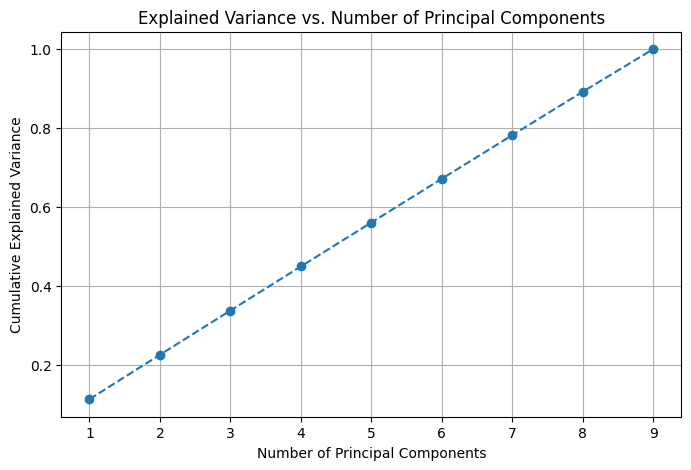

Explained Variance Ratios: [0.11430325 0.1125037  0.11183225 0.11163494 0.11100759 0.11079829
 0.11026287 0.1099252  0.10773192]
Cumulative Variance: [0.11430325 0.22680695 0.3386392  0.45027413 0.56128172 0.67208001
 0.78234288 0.89226808 1.        ]


In [27]:
# Introducing PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Principal Components")
plt.grid()
plt.show()

# Print explained variance ratios
print("Explained Variance Ratios:", explained_variance)
print("Cumulative Variance:", cumulative_variance)

In [28]:
# Transforming data using PCA
x_pca = pca.transform(scaled_data)
X_train,X_test,y_train,y_test = train_test_split(x_pca, target, test_size=0.2, random_state=42)

In [29]:
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)

0:	learn: 38.8099130	total: 155ms	remaining: 2m 34s
1:	learn: 38.8097876	total: 300ms	remaining: 2m 29s
2:	learn: 38.8096757	total: 470ms	remaining: 2m 36s
3:	learn: 38.8095552	total: 636ms	remaining: 2m 38s
4:	learn: 38.8094566	total: 809ms	remaining: 2m 40s
5:	learn: 38.8093522	total: 1s	remaining: 2m 45s
6:	learn: 38.8092402	total: 1.19s	remaining: 2m 48s
7:	learn: 38.8091345	total: 1.35s	remaining: 2m 47s
8:	learn: 38.8090283	total: 1.57s	remaining: 2m 52s
9:	learn: 38.8089207	total: 1.77s	remaining: 2m 55s
10:	learn: 38.8088246	total: 1.97s	remaining: 2m 56s
11:	learn: 38.8087208	total: 2.15s	remaining: 2m 57s
12:	learn: 38.8086274	total: 2.37s	remaining: 3m
13:	learn: 38.8085270	total: 2.6s	remaining: 3m 3s
14:	learn: 38.8084344	total: 2.8s	remaining: 3m 3s
15:	learn: 38.8083360	total: 2.99s	remaining: 3m 4s
16:	learn: 38.8082433	total: 3.2s	remaining: 3m 5s
17:	learn: 38.8081542	total: 3.4s	remaining: 3m 5s
18:	learn: 38.8080814	total: 3.6s	remaining: 3m 5s
19:	learn: 38.8079969

In [ ]:
# Predicting the normal training set
